In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from pmdarima import ARIMA
from pmdarima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

The data is in an xlsx file

The file contains information on drought levels, organized by city and state, reported since January 2003 and recorded biweekly

In [2]:
file_name = "sequia2023.xlsx"
sheet_name = 0
df = pd.read_excel(file_name, sheet_name=sheet_name)

In [3]:
df.head()

,CVE_CONCATENADA,CVE_ENT,CVE_MUN,NOMBRE_MUN,ENTIDAD,ORG_CUENCA,CLV_OC,CON_CUENCA,CVE_CONC,2003-01-31 00:00:00,...,2023-08-15 00:00:00,2023-08-31 00:00:00,2023-09-15 00:00:00,2023-09-30 00:00:00,2023-10-15 00:00:00,2023-10-31 00:00:00,2023-11-15 00:00:00,2023-11-30 00:00:00,2023-12-15 00:00:00,2023-12-31 00:00:00
0,1001,1,1,Aguascalientes,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D1,D1
1,1002,1,2,Asientos,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D2,D1,D1
2,1003,1,3,Calvillo,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D3,D3
3,1004,1,4,Cosío,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D2,D2,D3,D3,D3,D3,D3,D3,D2,D2
4,1005,1,5,Jesús María,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D2,D2


#### Data preparation 

We will remove the unnecessary columns, as the majority of them are identification keys.

We will also remove the cities from each state, as our focus will be uniquely on states. We only need to know the state and the historical data of the droughts.

In [4]:
df = df.drop(columns=["CVE_CONCATENADA","CVE_ENT","CVE_MUN","NOMBRE_MUN", "ORG_CUENCA", "CLV_OC","CVE_CONC","CON_CUENCA","CVE_CONC"])

In [5]:
df.head()

,ENTIDAD,2003-01-31 00:00:00,2003-02-28 00:00:00,2003-03-31 00:00:00,2003-04-30 00:00:00,2003-05-31 00:00:00,2003-06-30 00:00:00,2003-07-31 00:00:00,2003-08-31 00:00:00,2003-09-30 00:00:00,...,2023-08-15 00:00:00,2023-08-31 00:00:00,2023-09-15 00:00:00,2023-09-30 00:00:00,2023-10-15 00:00:00,2023-10-31 00:00:00,2023-11-15 00:00:00,2023-11-30 00:00:00,2023-12-15 00:00:00,2023-12-31 00:00:00
0,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D1,D1
1,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D2,D1,D1
2,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D3,D3
3,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D2,D2,D3,D3,D3,D3,D3,D3,D2,D2
4,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D2,D2


#### Replacing the drought levels with numerical values as follows:

1. Minimum (10% water reduction) D0 = 1

2. Moderate (15%) D1= 2
   
3. Moderate (25%) D2= 3

4. Severe (40%) D3= 4

5. Critical (>40%) D4= 5

In [6]:
df_replace = df.replace({'D0': 1,'D1':2,'D2':3,'D3':4,'D4':5})

#### Missing values:
All NA values do not indicate missing data; rather, they signify that no drought was reported on those days. Therefore, we will replace them with 0.

In [7]:
df_replace=df_replace.fillna(0)

In [8]:
df_replace.head()

,ENTIDAD,2003-01-31 00:00:00,2003-02-28 00:00:00,2003-03-31 00:00:00,2003-04-30 00:00:00,2003-05-31 00:00:00,2003-06-30 00:00:00,2003-07-31 00:00:00,2003-08-31 00:00:00,2003-09-30 00:00:00,...,2023-08-15 00:00:00,2023-08-31 00:00:00,2023-09-15 00:00:00,2023-09-30 00:00:00,2023-10-15 00:00:00,2023-10-31 00:00:00,2023-11-15 00:00:00,2023-11-30 00:00:00,2023-12-15 00:00:00,2023-12-31 00:00:00
0,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0
1,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0
2,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0
4,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0


The 'Entidad' column contains the states of the country, repeated because the database is divided into cities. However, our objective is to determine the drought level by state. Therefore, the maximum value will be taken, meaning the highest drought level among all the cities belonging to a specific state will be assigned to the state. This approach is preferred because if there is a possibility that one city within the state has a high drought level, it is more prudent to consider the most critical situation rather than the average, for example.

In [9]:
df_replace["ENTIDAD"].unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila de Zaragoza', 'Colima', 'Chiapas',
       'Chihuahua', 'Ciudad de México', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'Estado de México',
       'Michoacán de Ocampo', 'Morelos', 'Nayarit', 'Nuevo León',
       'Oaxaca', 'Puebla', 'Querétaro de Arteaga', 'Quintana Roo',
       'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas',
       'Tlaxcala', 'Veracruz de Ignacio de la Llave', 'Yucatán',
       'Zacatecas'], dtype=object)

In [10]:
new_df = df_replace.groupby('ENTIDAD').max()
new_df.head()

,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,...,2023-08-15,2023-08-31,2023-09-15,2023-09-30,2023-10-15,2023-10-31,2023-11-15,2023-11-30,2023-12-15,2023-12-31
ENTIDAD,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
Baja California,4.0,3.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Baja California Sur,3.0,3.0,3.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Campeche,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
Chiapas,2.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,1.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


We will create a new dataframe containing the maximum values and transpose it, so that each state is represented in a separate column.

In [11]:
df_trans = new_df.T 
df_trans.head()

ENTIDAD,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila de Zaragoza,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
2003-01-31 00:00:00,0.0,4.0,3.0,1.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,0.0,0.0
2003-02-28 00:00:00,0.0,3.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,1.0,0.0
2003-03-31 00:00:00,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,0.0
2003-04-30 00:00:00,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0
2003-05-31 00:00:00,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0


In [12]:
df_trans.index = pd.to_datetime(df_trans.index)

In [13]:
df_trans.head()

ENTIDAD,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila de Zaragoza,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
2003-01-31,0.0,4.0,3.0,1.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,0.0,0.0
2003-02-28,0.0,3.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,1.0,0.0
2003-03-31,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,0.0
2003-04-30,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0
2003-05-31,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0


In [14]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 370 entries, 2003-01-31 to 2023-12-31
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Aguascalientes                   370 non-null    float64
 1   Baja California                  370 non-null    float64
 2   Baja California Sur              370 non-null    float64
 3   Campeche                         370 non-null    float64
 4   Chiapas                          370 non-null    float64
 5   Chihuahua                        370 non-null    float64
 6   Ciudad de México                 370 non-null    float64
 7   Coahuila de Zaragoza             370 non-null    float64
 8   Colima                           370 non-null    float64
 9   Durango                          370 non-null    float64
 10  Estado de México                 370 non-null    float64
 11  Guanajuato                       370 non-null    float64
 12  Gue

In [15]:
df_trans = df_trans.astype(int)

In [16]:
df_trans.describe()

ENTIDAD,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila de Zaragoza,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,...,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,0.854054,2.321622,1.159459,1.332432,1.829730,2.548649,0.802703,2.437838,0.981081,2.045946,...,1.167568,1.945946,2.000000,2.835135,1.389189,2.383784,0.810811,2.121622,1.297297,1.597297
std,1.223216,1.380003,1.191196,1.074603,1.249686,1.359125,0.840372,1.555714,1.047474,1.355726,...,0.987196,1.254714,1.333333,1.188179,1.287796,1.428990,0.853427,1.147080,1.078614,1.320053
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.250000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,3.000000,1.000000,2.000000,...,1.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
75%,2.000000,4.000000,2.000000,2.000000,3.000000,3.000000,1.000000,4.000000,2.000000,3.000000,...,2.000000,3.000000,3.000000,4.000000,2.000000,4.000000,1.000000,3.000000,2.000000,3.000000
max,5.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,...,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000


We observe that nearly all states exhibit maximum values of 5, which is the highest level of drought.

In [17]:
high= df_trans.describe().loc['mean'] >= 2
results = df_trans.describe().loc[:, high]
print(results)

ENTIDAD  Baja California   Chihuahua  Coahuila de Zaragoza     Durango  \
count         370.000000  370.000000            370.000000  370.000000   
mean            2.321622    2.548649              2.437838    2.045946   
std             1.380003    1.359125              1.555714    1.355726   
min             0.000000    0.000000              0.000000    0.000000   
25%             1.000000    1.250000              1.000000    1.000000   
50%             2.000000    2.000000              3.000000    2.000000   
75%             4.000000    3.000000              4.000000    3.000000   
max             5.000000    5.000000              5.000000    5.000000   

ENTIDAD     Jalisco  Michoacán de Ocampo      Oaxaca     Sinaloa      Sonora  \
count    370.000000           370.000000  370.000000  370.000000  370.000000   
mean       2.016216             2.094595    2.227027    2.000000    2.835135   
std        1.161607             1.163689    1.224114    1.333333    1.188179   
min        0.

In [18]:
df_trans.mean().mean()

1.7191722972972974

The country's average is 1.79, which means that the country suffers from many droughts, a good average would be a value close to 0.

For this project we will randomly select 3 states, one from each region of Mexico: Colima, Morelos, Quintana Roo and Sonora to apply the model

In [19]:
df_new2  = df_trans.loc[:, ['Colima', 'Morelos','Quintana Roo','Sonora']]
df_new2.head()

ENTIDAD,Colima,Morelos,Quintana Roo,Sonora
2003-01-31,0,3,0,5
2003-02-28,0,3,0,5
2003-03-31,0,3,0,5
2003-04-30,0,3,0,5
2003-05-31,0,3,0,5


We will check if our index has a biweekly frequency, if it does not, we will adjust it accordingly

In [20]:
date_diffs = df_new2.index.to_series().diff().dropna()
print(date_diffs.value_counts())

15 days    157
31 days     77
16 days     69
30 days     45
28 days      8
13 days      8
29 days      3
14 days      2
Name: count, dtype: int64


The frequency of our time series is very irregular. We could keep it biweekly, but we would need to interpolate many data points. Therefore, we will group them monthly using the highest value, as we did previously

In [21]:
orig_df = df_new2.copy()

In [22]:
df_new2 = df_new2.resample('M').max()

In [23]:
df_new2.index = pd.to_datetime(df_new2.index)

In [24]:
date_diffs = df_new2.index.to_series().diff().dropna()
print(date_diffs.value_counts())

31 days    146
30 days     84
28 days     16
29 days      5
Name: count, dtype: int64


In [25]:
print(df_new2.index.freq) 

<MonthEnd>


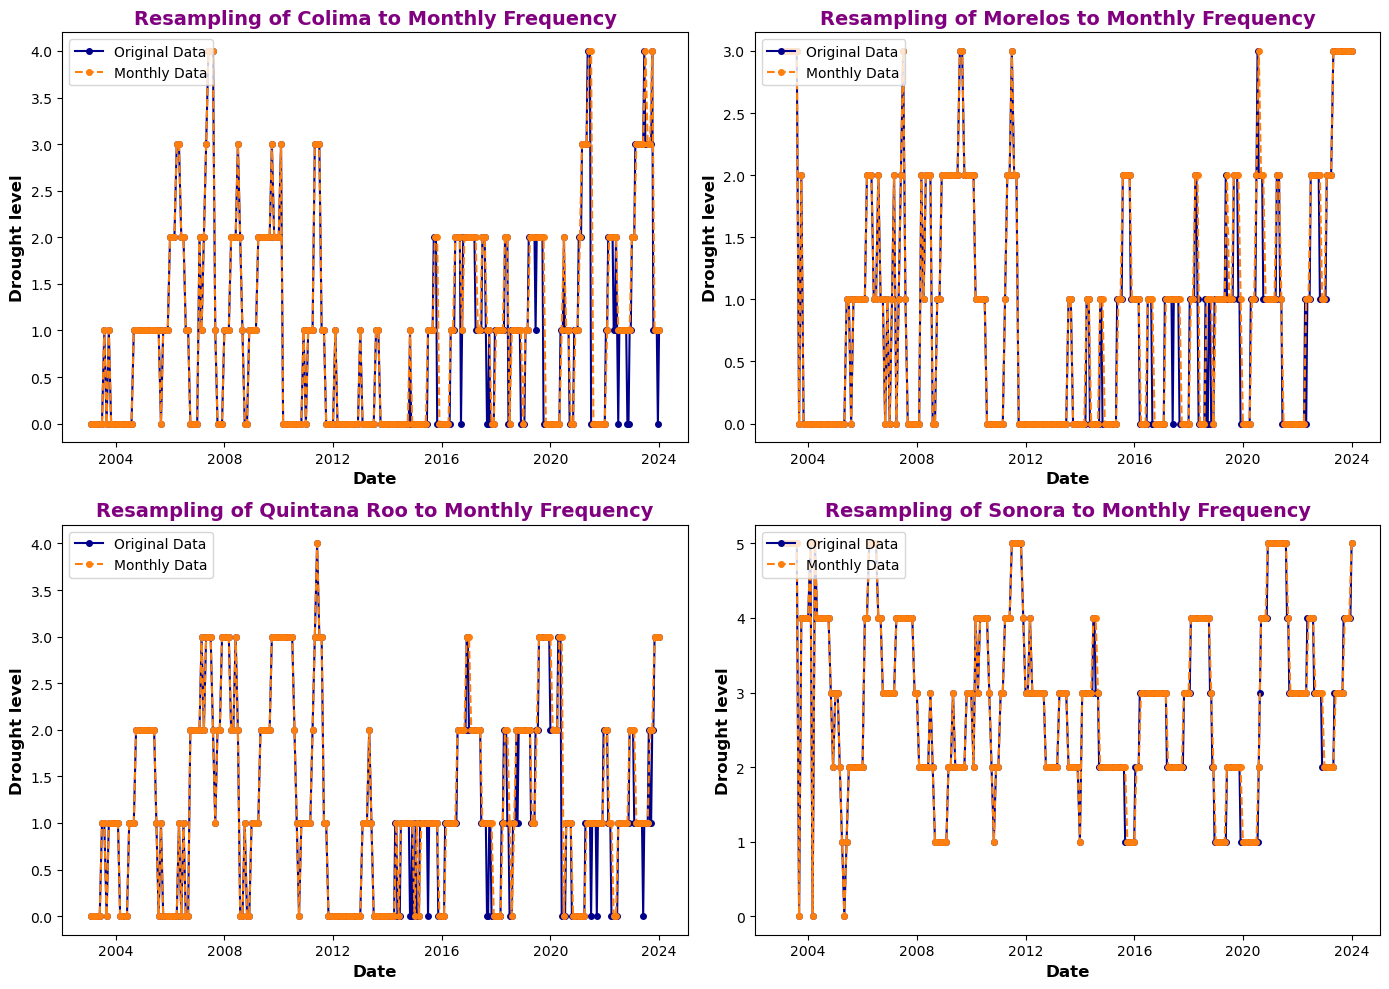

In [26]:
num_cols = len(df_new2.columns)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(df_new2.columns):
    axes[i].plot(orig_df.index, orig_df[col], label='Original Data', marker='o', markersize=4,linestyle='-', color='darkblue')
    axes[i].plot(df_new2.index, df_new2[col], label='Monthly Data', marker='o',markersize=4, linestyle='--', color='#FF7F0E')
    axes[i].set_xlabel('Date',fontweight='bold',fontsize=12)
    axes[i].set_ylabel('Drought level',fontweight='bold',fontsize=12)  
    axes[i].set_title(f'Resampling of {col} to Monthly Frequency',fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'purple'})
    axes[i].legend(loc='upper left')
    
plt.tight_layout()
plt.show()

It was also plotted by grouping with the mean, but using the maximum values fits the original data better

Once our data is prepared, we will plot the drought levels for all states to observe their behavior since 2003.

In [27]:
print(f"Data range: {df_new2.index.min()} to {df_new2.index.max()}")

Data range: 2003-01-31 00:00:00 to 2023-12-31 00:00:00


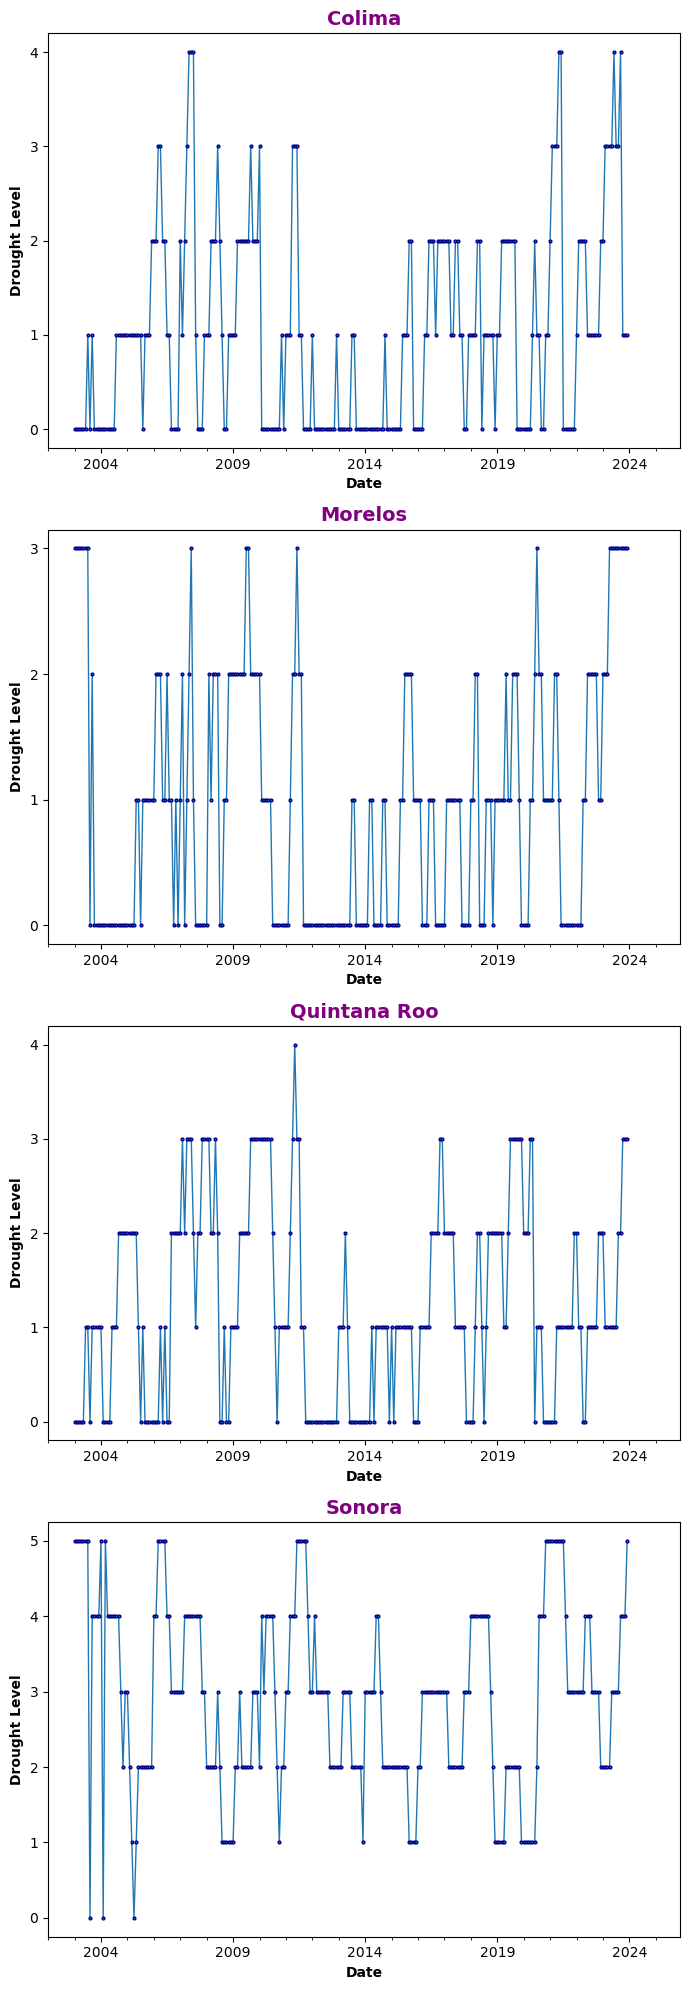

In [28]:
fig, axes = plt.subplots(nrows=len(df_new2.columns), ncols=1, figsize=(7, 5 * len(df_new2.columns)))


start_year = 2002 
end_year = 2025    


for i, col in enumerate(df_new2.columns):
    df_new2[col].plot(ax=axes[i], marker='o', markersize=2, markeredgecolor='darkblue', linewidth=1)

    
    axes[i].set_ylabel('Drought Level', fontweight='bold')  
    axes[i].set_xlabel('Date', fontweight='bold')
    axes[i].set_title(col, fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'purple'})

    
    axes[i].set_xlim(pd.Timestamp(f'{start_year}-01-31'), pd.Timestamp(f'{end_year}-12-31'))

    
    y_ticks = range(int(df_new2[col].min()), int(df_new2[col].max()) + 1) 
    axes[i].set_yticks(y_ticks)


plt.tight_layout()
plt.show()

To observe the recent trends over the past 2 years, we will graph the last 49 records

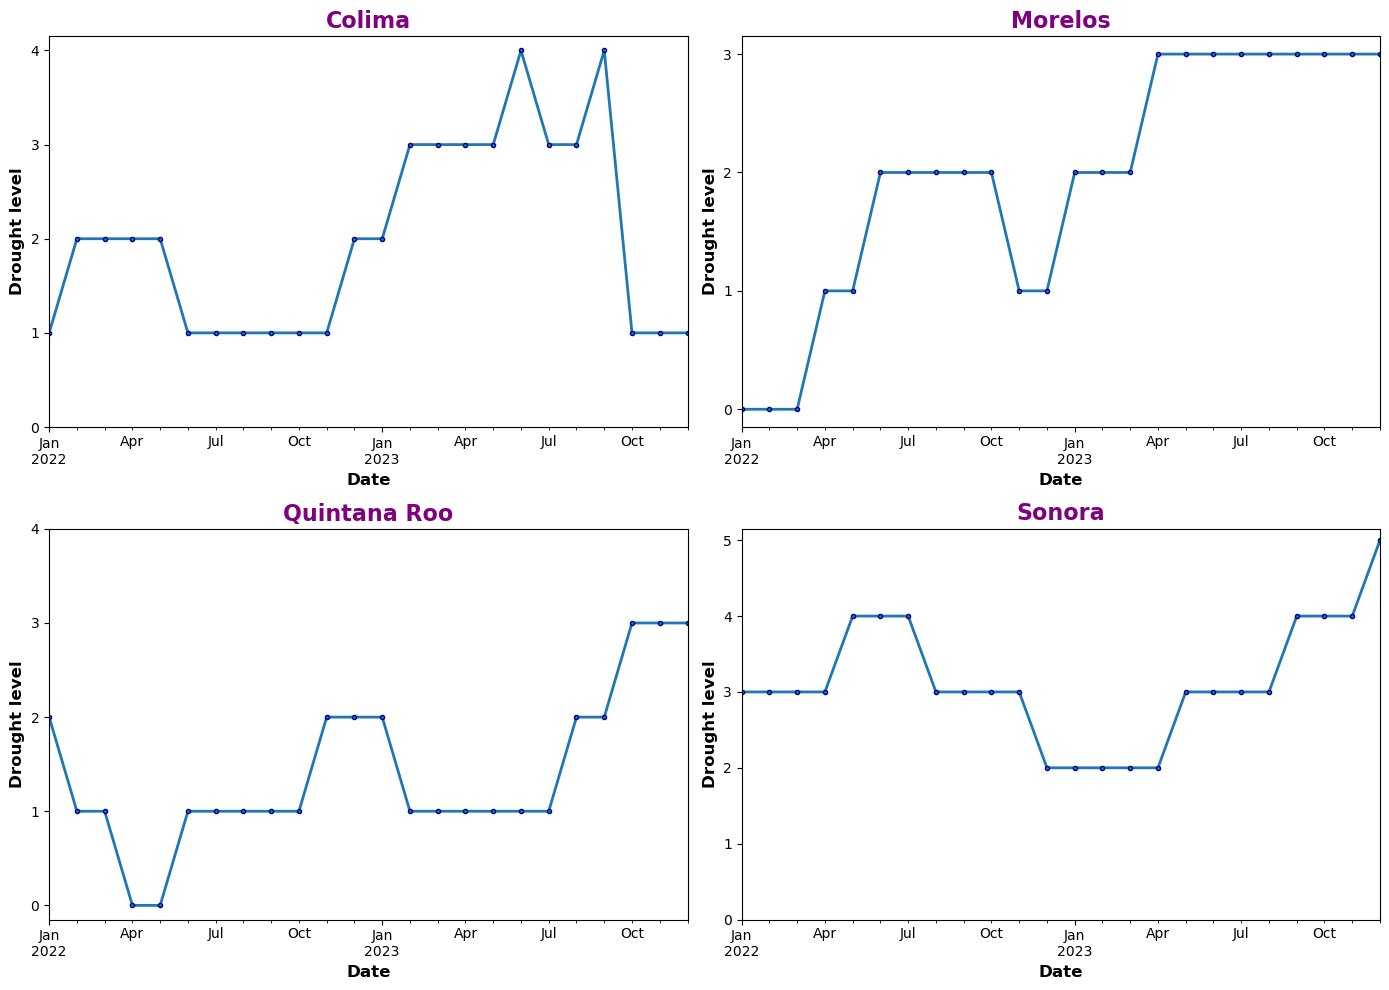

In [29]:
ultimas_20_filas = df_new2.tail(24)

#fig, axes = plt.subplots(nrows=len(df_new2.columns), ncols=1, figsize=(7, 5*len(df_new2.columns)))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(df_new2.columns):
    ultimas_20_filas[col].plot(ax=axes[i],marker='o',markersize=3,markeredgecolor='darkblue',linewidth=2)
    axes[i].set_ylabel('Drought level',fontweight='bold',fontsize=12)  
    axes[i].set_xlabel('Date',fontweight='bold',fontsize=12)
    axes[i].set_title(col,fontdict={'fontsize': 16, 'fontweight': 'bold', 'color': 'purple'}) 
    axes[i].xaxis.set_tick_params(rotation=0)  
    y_ticks = range(int(df_new2[col].min()), int(df_new2[col].max()) + 1) 
    axes[i].set_yticks(y_ticks)

plt.tight_layout()

plt.show()

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.ticker as plticker

We have our data prepared to apply the model for forecasting. For this project, we will utilize $ARIMA$, as it is a statistical forecasting model.
In the model, the parameters p,d y q, are utilized, each representing a component:

* p for the autoregressive element
* d number of differencing that have been performed
* q for the moving average element

It is not necessary to use all three components, we can have combinations where one or two components are 0, meaning they are not utilized.

The next step in the process will be to determine these parameters for the series.

####  Stationarity (I)
We need our data to be stationary to ensure that the forecasts are more reliable. 

Therefore, we will conduct two tests for each column: the KPSS Test and the ADF Test. Both tests will compare the p-value against the alpha level (0.05) to determine whether the data series is stationary or not.

If:

p-value < $\alpha$ (0.05)

Kpss test = the series is non-stationary and thus needs to be differenced.

ADF test = the series is stationary.

If the ADF indicates stationarity and the KPSS indicates non-stationarity, we might be in a situation of "difference stationarity." This means we need to apply differencing to make the series stationary.

The purpose of differencing is to make the time series stationary.

We need to difference the series until it becomes stationary, but always seeking the minimum differencing; otherwise, the series could be over-differenced which it will affect the model parameters.

In [31]:
orig_df2 = df_new2.copy()



State: Colima

Test stationarity for original series
-------------------------------------
ADF Statistic: -6.1738498476755055, p-value: 6.704177979672311e-08
KPSS Statistic: 0.3331750435428417, p-value: 0.1

It is stationary.


State: Morelos

Test stationarity for original series
-------------------------------------
ADF Statistic: -5.587569230333287, p-value: 1.3520016570162488e-06
KPSS Statistic: 0.20134335898859393, p-value: 0.1

It is stationary.


C:\Users\dnisg\AppData\Local\Temp\ipykernel_22132\1451250382.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_22132\1451250382.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_22132\1451250382.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_22132\1451250382.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-val



State: Quintana Roo

Test stationarity for original series
-------------------------------------
ADF Statistic: -5.020951381309017, p-value: 2.0168970869390464e-05
KPSS Statistic: 0.09558142508150556, p-value: 0.1

It is stationary.


State: Sonora

Test stationarity for original series
-------------------------------------
ADF Statistic: -4.541264200375415, p-value: 0.00016550061304177767
KPSS Statistic: 0.13903784463564642, p-value: 0.1

It is stationary.


C:\Users\dnisg\AppData\Local\Temp\ipykernel_22132\1451250382.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_22132\1451250382.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_22132\1451250382.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result= kpss(df_new2[col])
C:\Users\dnisg\AppData\Local\Temp\ipykernel_22132\1451250382.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-val

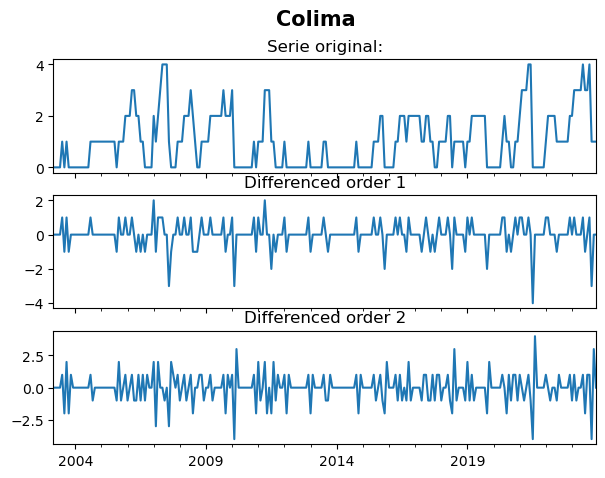

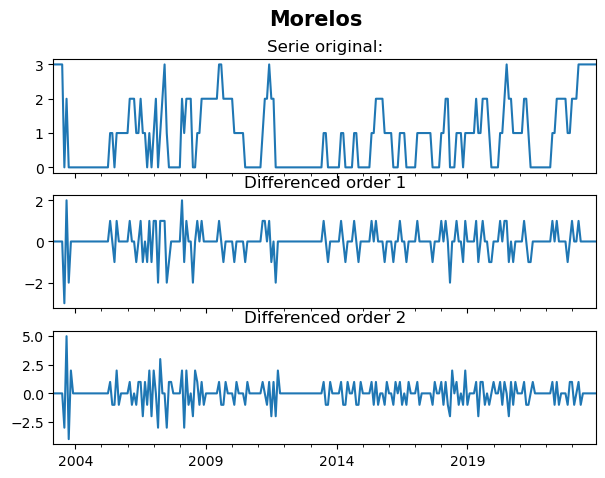

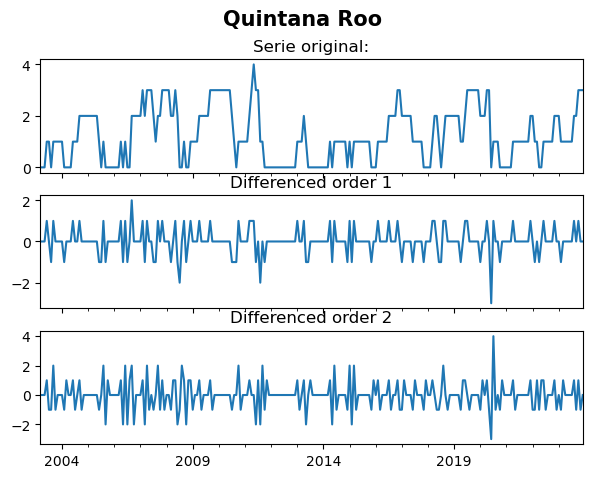

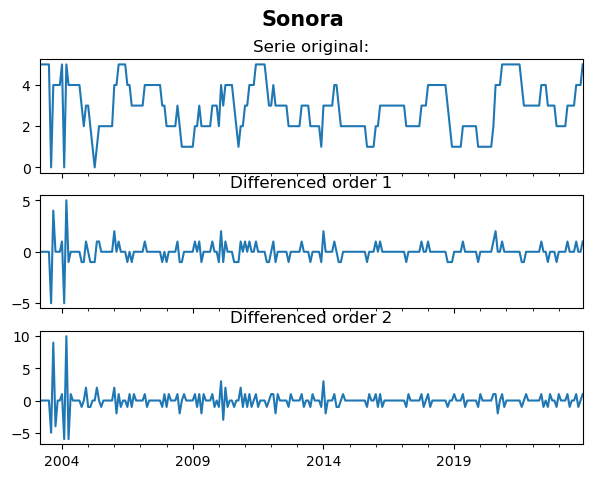

In [32]:
warnings.filterwarnings("default")
datos_diff_1 = {}
datos_diff_2 = {}
value_d= []
for i, col in enumerate(df_new2.columns):
    datos_diff_1[col] = df_new2[col].diff().dropna()
    datos_diff_2[col] = datos_diff_1[col].diff().dropna()
    print('\n')
    print("State:",df_new2.columns[i])
    print('\nTest stationarity for original series')
    print('-------------------------------------')
    adfuller_result = adfuller(df_new2[col])
    kpss_result= kpss(df_new2[col])
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
   
    adfuller_result = adfuller(df_new2[col])
    kpss_result= kpss(df_new2[col])
    
    if kpss_result[1] < 0.05 or adfuller_result[1] >0.05:
            
     print('\nTest stationarity for differenced series (order=1)')
     print('--------------------------------------------------')
     adfuller_result1 = adfuller(datos_diff_1[col])
     kpss_result = kpss(df_new2[col].diff().dropna())
     print(f'ADF Statistic: {adfuller_result1[0]}, p-value: {adfuller_result1[1]}')
     print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
             
     if kpss_result[1] < 0.05 or adfuller_result1[1] >0.05:
            print('\nTest stationarity for differenced series (order=2)')
            print('--------------------------------------------------')
            adfuller_result2 = adfuller(datos_diff_2[col])
            kpss_result = kpss(df_new2[col].diff().diff().dropna())
            print(f'ADF Statistic: {adfuller_result2[0]}, p-value: {adfuller_result2[1]}')
            print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
         
            #df_new2[col]=datos_diff_2[col]
            print("The serie is differenced (order 2)")
            d=2
            value_d.append(d)
     else:
        #df_new2[col]=datos_diff_1[col]
        print("\n\nThe serie is differenced (order 1)")
        d=1
        value_d.append(d)
    else:
        print("\nIt is stationary.")
        d=0
        value_d.append(d)
        
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
    fig.suptitle(df_new2.columns[i],fontweight='bold',fontsize=15)
    orig_df2[col].plot(ax=axs[0], title='\nSerie original:')
    datos_diff_1[col].plot(ax=axs[1], title='\nDifferenced order 1')
    datos_diff_2[col].plot(ax=axs[2], title='\nDifferenced order 2')

            

As we saw, if the series is stationary, it is not differenced and d=0

If the series is non-stationary, it is differenced twice, but we will take the first differencing if it passes both tests for stationarity, making d=1. If it needs another differencing, d=2. 

The d values for each feature will be stored in value_d, we will use this value for the model we are going to employ.

In [33]:
value_d

[0, 0, 0, 0]

#### Autocorrelation Function (ACF) for MA

After having all our series stationary, we will plot the ACF to identify the value of q

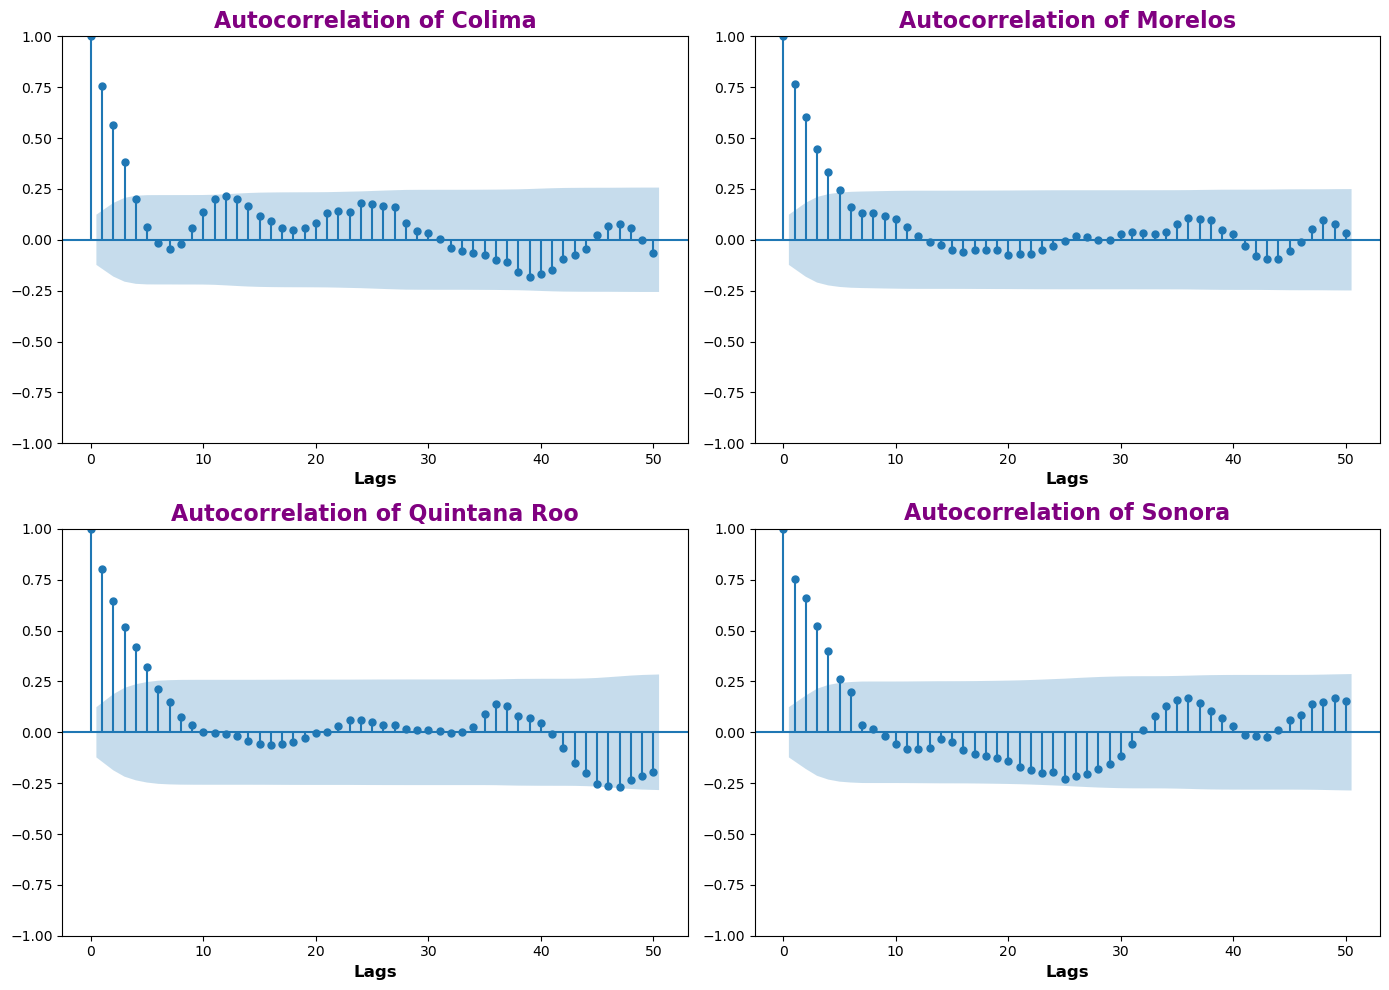

In [34]:
num_cols = len(df_new2.columns)
df_new2=df_new2.fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()
for i, col in enumerate(df_new2.columns):
    plot_acf(df_new2[col], ax=axes[i], lags=50)
    axes[i].set_title(f'Autocorrelation of {col}',fontdict={'fontsize': 16, 'fontweight': 'bold', 'color': 'purple'})   
    axes[i].set_xlabel('Lags',fontweight='bold',fontsize=12)

plt.tight_layout()
plt.show()

The ACF calculates the correlation between a time series and its lagged values. The lag at which the ACF falls provides an estimate of the value of q. 

We will assign q for each series conservatively.

In [35]:
value_q=[2,1,2,2]

#### Partial Autocorrelation Function (PACF) for AR
The PACF helps identify the value of p

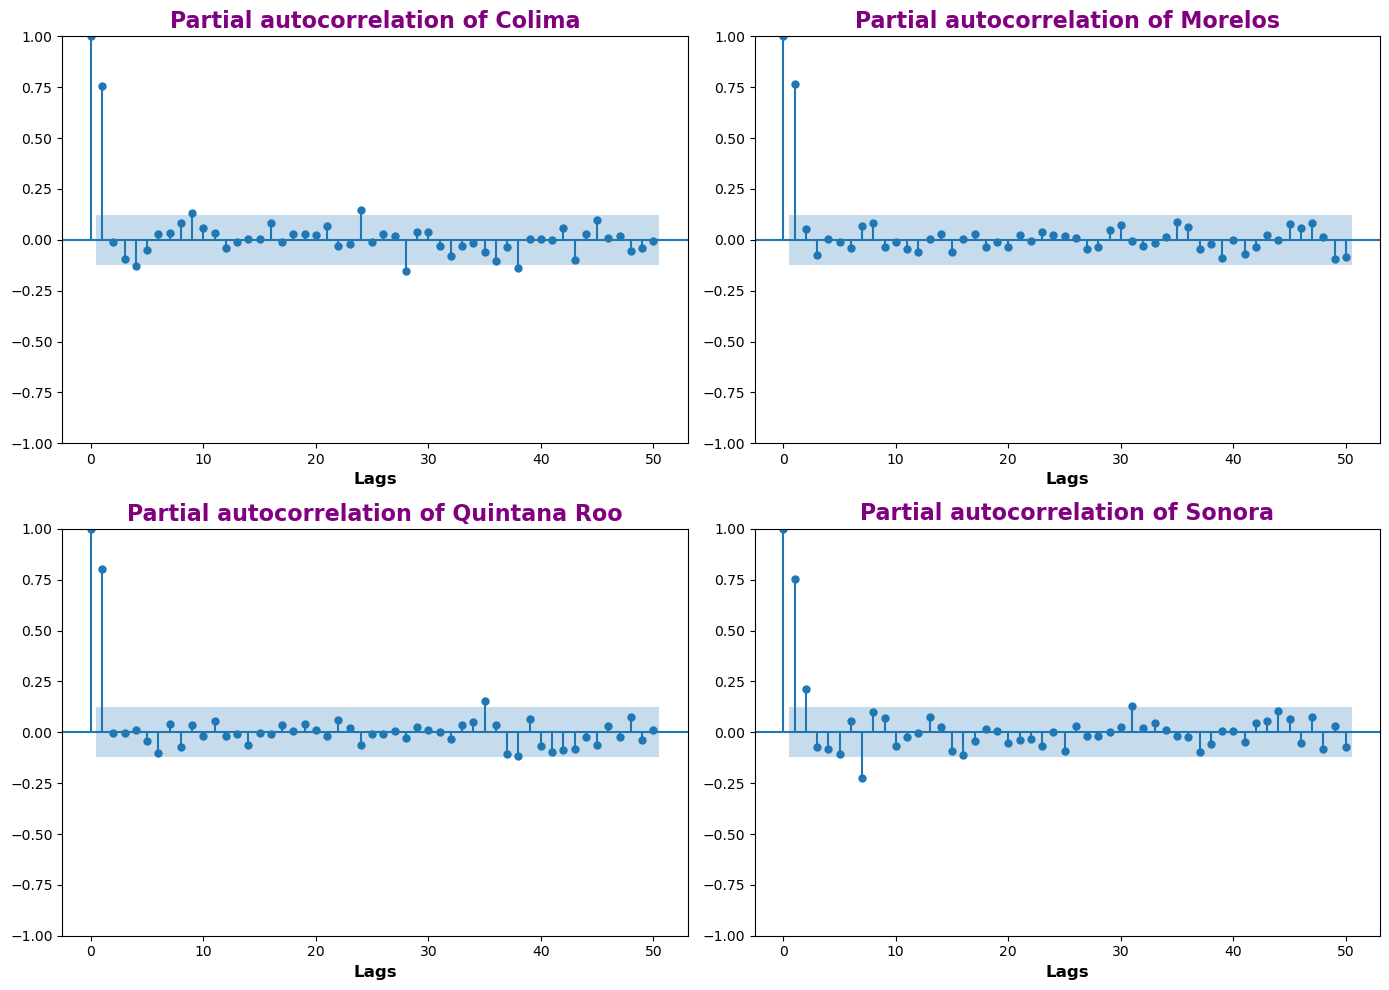

In [36]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(df_new2.columns):
    plot_pacf(df_new2[col], ax=axes[i],lags=50)
    axes[i].set_title(f'Partial autocorrelation of {col}',fontdict={'fontsize': 16, 'fontweight': 'bold', 'color': 'purple'}) 
    axes[i].set_xlabel('Lags',fontweight='bold',fontsize=12)

plt.tight_layout()
plt.show()

The PACF measures the correlation between a lagged value and the current value of the time series, taking into account the effect of intermediate lags. The lag at which the PACF cuts off provides an indication of the value of p

In [37]:
value_p=[2,2,2,3] 

In [38]:
names=df_new2.columns
valuesmodel = pd.DataFrame()

In [39]:
valuesmodel = pd.concat([valuesmodel, pd.DataFrame([value_d])], ignore_index=True)
valuesmodel = pd.concat([valuesmodel, pd.DataFrame([value_q])], ignore_index=True)
valuesmodel = pd.concat([valuesmodel, pd.DataFrame([value_p])], ignore_index=True)

Creating a new dataframe to store the model parameters for each feature

In [40]:
valuesmodel.columns=names
new_index=['d', 'q', 'p']
valuesmodel = valuesmodel.set_index(pd.Index(new_index))
valuesmodel

ENTIDAD,Colima,Morelos,Quintana Roo,Sonora
d,0,0,0,0
q,2,1,2,2
p,2,2,2,3


In [41]:
from statsmodels.tsa.arima.model import ARIMA

## SONORA (Northern Region)

In [42]:
print(valuesmodel["Sonora"])

d    0
q    2
p    3
Name: Sonora, dtype: int64


We will use ARIMA with the values obtained from the analyses above

In [43]:
arima = ARIMA(df_new2["Sonora"].tolist(), order = (3, 0, 2))

arima_fit = arima.fit()

arima_fit.summary()

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -285.990
Date:                Tue, 05 Nov 2024   AIC                            585.979
Time:                        01:13:34   BIC                            610.685
Sample:                             0   HQIC                           595.921
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9722      0.262     11.354      0.000       2.459       3.485
ar.L1          0.2839      0.150      1.888      0.059      -0.011       0.579
ar.L2         -0.2646      0.129     -2.055      0.040      -0.517      -0.012
ar.L3          0.5632      0.112      5.051      0.000       0.345       0.782
ma.L1          0.3508      0.146      2.402      0.016       0.065       0.637
ma.L2          0.7487      0.109      6.852      0.000       0.535       0.963
sigma2         0.5638      0.040     14.082      0.000       0.485       0.642
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               761.68
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We obtained an AIC of 585, but we are going to try other combinations to find the smallest score.

In [44]:
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa

In [45]:
aic_values = []

for ari in range(1, 4):  # p
    for d in range(0, 4):  # d
        for maj in range(0, 4):  # q
            try:
                
                arima_model = ARIMA(df_new2["Sonora"].tolist(), order=(ari, d, maj))
                arima_model_fit = arima_model.fit()
                
                
                aic_values.append([ari, d, maj, arima_model_fit.aic])
            except ValueError:
                continue 


aic_df = pd.DataFrame(aic_values, columns=['p', 'd', 'q', 'AIC'])


best_aic_row = aic_df.loc[aic_df['AIC'].idxmin()]

print(aic_values)
print(f"Best AIC: {best_aic_row['AIC']}")
print(f"Parameters: p={best_aic_row['p']}, d={best_aic_row['d']}, q={best_aic_row['q']}")

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


[[1, 0, 0, 596.7914761982058], [1, 0, 1, 588.8558253310403], [1, 0, 2, 585.4832900342001], [1, 0, 3, 587.1215171819453], [1, 1, 0, 595.3375273413859], [1, 1, 1, 597.3258836958321], [1, 1, 2, 596.4341032124913], [1, 1, 3, 598.3406238223665], [1, 2, 0, 721.5255074989293], [1, 2, 1, 602.047827813441], [1, 2, 2, 604.0460341873518], [1, 2, 3, 603.2193632872732], [1, 3, 0, 943.6100800190732], [1, 3, 1, 728.1751602994179], [1, 3, 2, 615.5123334941173], [1, 3, 3, 617.6603607644843], [2, 0, 0, 585.9431668141017], [2, 0, 1, 587.1874693721697], [2, 0, 2, 584.5695550601366], [2, 0, 3, 587.2595151413949], [2, 1, 0, 597.3259665324658], [2, 1, 1, 586.7039625093635], [2, 1, 2, 601.3257735874348], [2, 1, 3, 590.1475090154803], [2, 2, 0, 680.7030542456744], [2, 2, 1, 604.0459270213236], [2, 2, 2, 603.6705439543985], [2, 2, 3, 605.1361977355518], [2, 3, 0, 855.7940652890059], [2, 3, 1, 688.1891477361611], [2, 3, 2, 617.5243334534848], [2, 3, 3, 619.5033255352121], [3, 0, 0, 586.8206860710924], [3, 0, 1, 

We found that with [3,0,1], the AIC is 584.51, the lowest among all options.

In [46]:
arima_obj = ARIMA(df_new2["Sonora"].tolist(), order = (3, 0, 1))

arima_obj_fit = arima_obj.fit()

arima_obj_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -286.260
Date:                Tue, 05 Nov 2024   AIC                            584.519
Time:                        01:13:44   BIC                            605.696
Sample:                             0   HQIC                           593.040
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9185      0.176     16.581      0.000       2.574       3.264
ar.L1          1.4655      0.108     13.510      0.000       1.253       1.678
ar.L2         -0.2404      0.094     -2.557      0.011      -0.425      -0.056
ar.L3         -0.2668      0.048     -5.597      0.000      -0.360      -0.173
ma.L1         -0.8700      0.112     -7.763      0.000      -1.090      -0.650
sigma2         0.5652      0.037     15.308      0.000       0.493       0.638
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1029.38
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
df_ARIMA=df_new2

In [48]:
pred = arima_obj_fit.fittedvalues

df_ARIMA['Sonora_Arima'] = pred

diffval = arima_obj_fit.resid + arima_obj_fit.fittedvalues
df_ARIMA['Sonora_diffval'] = diffval

df_ARIMA.head()

ENTIDAD,Colima,Morelos,Quintana Roo,Sonora,Sonora_Arima,Sonora_diffval
2003-01-31,0,3,0,5,2.918521,5.0
2003-02-28,0,3,0,5,4.518073,5.0
2003-03-31,0,3,0,5,4.624301,5.0
2003-04-30,0,3,0,5,4.594363,5.0
2003-05-31,0,3,0,5,4.566749,5.0


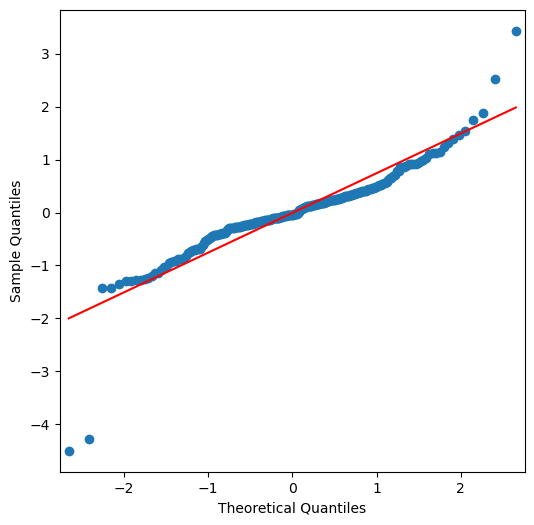

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))

residuals = arima_obj_fit.resid[2:]
sm.qqplot(residuals, line='s', ax=ax)
plt.show()

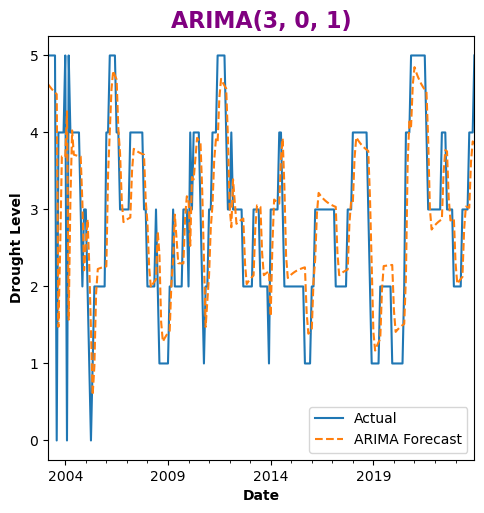

In [50]:
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)

df_ARIMA['Sonora_diffval'].iloc[2:].plot( linestyle='-', ax=axarr, label='Actual')
df_ARIMA['Sonora_Arima'].iloc[2:].plot( linestyle='--', ax=axarr, label='ARIMA Forecast')
axarr.set_title('ARIMA(3, 0, 1)',fontsize= 16, fontweight= 'bold', color= 'purple')
axarr.set_xlabel('Date',fontweight='bold')
axarr.set_ylabel('Drought Level',fontweight='bold')
axarr.legend()

plt.show()

We observe that our forecast is similar but not exactly the same. This is a good result, as if it were perfect, it could indicate overfitting. We will conduct cross-validation to test the model

#### Out-of-Time Cross validation
To do out-of-time cross-validation, we will create the training and testing dataset by splitting the time series into 2 contiguous segments, 85% and 15% respectively.

We will compare our forecast against the actual values.

In [51]:
Sonora=df_new2["Sonora"]
Sonora

2003-01-31    5
2003-02-28    5
2003-03-31    5
2003-04-30    5
2003-05-31    5
             ..
2023-08-31    3
2023-09-30    4
2023-10-31    4
2023-11-30    4
2023-12-31    5
Freq: M, Name: Sonora, Length: 252, dtype: int32

In [52]:
p_train1 = 0.85 ### 15% for test data

train1 = Sonora[:int(len(Sonora) * p_train1)]
test1 = Sonora[int(len(Sonora) * p_train1):]
train1

2003-01-31    5
2003-02-28    5
2003-03-31    5
2003-04-30    5
2003-05-31    5
             ..
2020-06-30    1
2020-07-31    2
2020-08-31    4
2020-09-30    4
2020-10-31    4
Freq: M, Name: Sonora, Length: 214, dtype: int32

In [53]:
len(test1)

38

Train dates : 2003-01-31 00:00:00 --- 2020-10-31 00:00:00  (n=214)
Test dates  : 2020-10-31 00:00:00 --- 2023-12-31 00:00:00  (n=39)


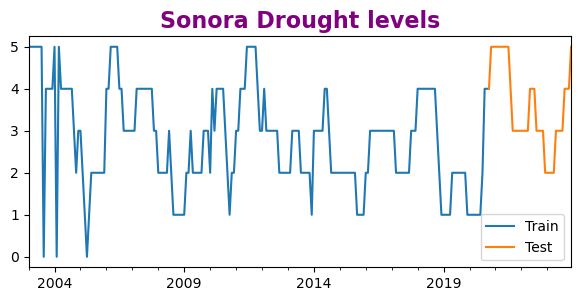

In [54]:

fin_train = '2020-10-31 00:00:00'
print(
    f"Train dates : {Sonora.index.min()} --- {Sonora.loc[:fin_train].index.max()}  "
    f"(n={len(Sonora.loc[:fin_train])})"
)
print(
    f"Test dates  : {Sonora.loc[fin_train:].index.min()} --- {Sonora.loc[:].index.max()}  "
    f"(n={len(Sonora.loc[fin_train:])})"
)
data_train = Sonora.loc[:fin_train]
data_test  = Sonora.loc[fin_train:]


fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='Train')
data_test.plot(ax=ax, label='Test')
ax.set_title('Sonora Drought levels',fontsize= 16, fontweight= 'bold', color= 'purple')
ax.legend();

We will apply the ARIMA model again using only the training data

In [55]:
arima_obj_So = ARIMA(data_train.tolist(), order = (3, 0, 1))

model_So_fit = arima_obj_So.fit()

model_So_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  214
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -252.947
Date:                Tue, 05 Nov 2024   AIC                            517.894
Time:                        01:13:45   BIC                            538.090
Sample:                             0   HQIC                           526.055
                                - 214                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8124      0.181     15.540      0.000       2.458       3.167
ar.L1          1.4738      0.109     13.576      0.000       1.261       1.687
ar.L2         -0.2400      0.097     -2.472      0.013      -0.430      -0.050
ar.L3         -0.2676      0.052     -5.178      0.000      -0.369      -0.166
ma.L1         -0.9085      0.108     -8.377      0.000      -1.121      -0.696
sigma2         0.6195      0.046     13.510      0.000       0.530       0.709
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               701.35
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
forecast_obj = model_So_fit.get_forecast(steps=39)
forecast_values = forecast_obj.predicted_mean  
confidence_intervals = forecast_obj.conf_int(alpha=0.05) 

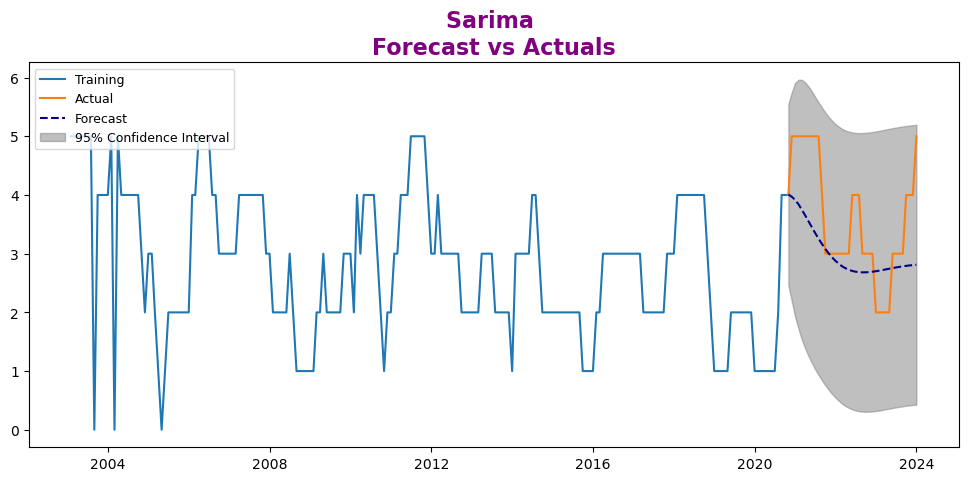

In [57]:

forecast_index = pd.date_range(start=data_train.index[-1], periods=39,freq='M')
fc_series = pd.Series(forecast_values, index=forecast_index)


forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': confidence_intervals[:, 0],
    'Upper CI': confidence_intervals[:, 1]
}, index=forecast_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train, label='Training')
plt.plot(data_test, label='Actual')
plt.plot(fc_series, label='Forecast',linestyle='--',color="darkblue")
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                 color='gray', alpha=0.5, label='95% Confidence Interval')

plt.title('Sarima \nForecast vs Actuals',fontsize= 16, fontweight= 'bold', color= 'purple')
plt.legend(loc='upper left', fontsize=9)
plt.show()

We can observe that the forecast does not resemble the actual values, but we will evaluate the performance using some metrics.

In [58]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

In [59]:
start = len(data_train)
end = len(data_train) + len(data_test) - 1

# Get predictions
predictions = model_So_fit.predict(start=start, end=end, dynamic=False, typ='levels')
predictions_series = pd.Series(predictions, index=data_test.index, name='ARIMA Predictions')


C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [60]:
data_test = pd.Series(data_test)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [61]:
def calculate_metrics(data_test, predictions_series):
    metrics = {
        'r2_score': r2_score(data_test, predictions_series),
        'mean_absolute_error': mean_absolute_error(data_test, predictions_series),
        'mean_squared_error': mean_squared_error(data_test, predictions_series),
        'root_mean_squared_error': np.sqrt(mean_squared_error(data_test, predictions_series)),
        'mean_absolute_percentage_error': np.mean(np.abs(predictions_series - data_test) 
                                                  / np.abs(data_test)) * 100
    }
    return metrics

In [62]:
evaluation_results = pd.DataFrame([calculate_metrics(data_test, predictions_series)])
evaluation_results['State']='Sonora'
evaluation_results['Model']="Arima"
evaluation_results["Scaled"]="No"
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,State,Model,Scaled
0,0.097926,0.763353,0.912156,0.955069,20.263722,Sonora,Arima,No


The model showed 9.7% accuracy as R2 score is 0.0979, A very low value, therefore we will try another model

## SARIMA

In [63]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
best_model = SARIMAX(df_new2["Sonora"], order = (3, 0, 1), seasonal_order = (3, 0, 1, 12)).fit(method='powell')

print(best_model.summary())

Optimization terminated successfully.
         Current function value: 1.166269
         Iterations: 5
         Function evaluations: 507
                                     SARIMAX Results                                      
Dep. Variable:                             Sonora   No. Observations:                  252
Model:             SARIMAX(3, 0, 1)x(3, 0, 1, 12)   Log Likelihood                -293.900
Date:                            Tue, 05 Nov 2024   AIC                            605.800
Time:                                    01:13:48   BIC                            637.565
Sample:                                01-31-2003   HQIC                           618.581
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

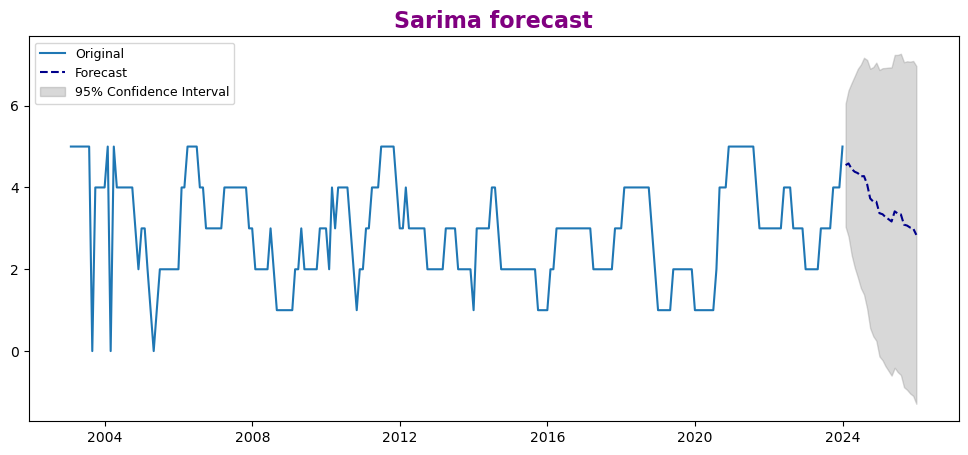

In [64]:
forecast_results = best_model.get_forecast(steps=24)

forecast_values = forecast_results.predicted_mean

confidence_intervals = forecast_results.conf_int()
forecast_index = pd.date_range(start=df_new2.index[-1] + pd.offsets.MonthEnd(1), periods=24, freq='M')


forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': confidence_intervals.iloc[:, 0],
    'Upper CI': confidence_intervals.iloc[:, 1]
}, index=forecast_index)

plt.figure(figsize=(12, 5), dpi=100)
plt.plot(df_new2["Sonora"], label='Original')

plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast',color="darkblue",linestyle='--')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

plt.title('Sarima forecast',fontsize= 16, fontweight= 'bold', color= 'purple')
plt.legend(loc='upper left', fontsize=9)
plt.show()

Optimization terminated successfully.
         Current function value: 1.209391
         Iterations: 5
         Function evaluations: 501


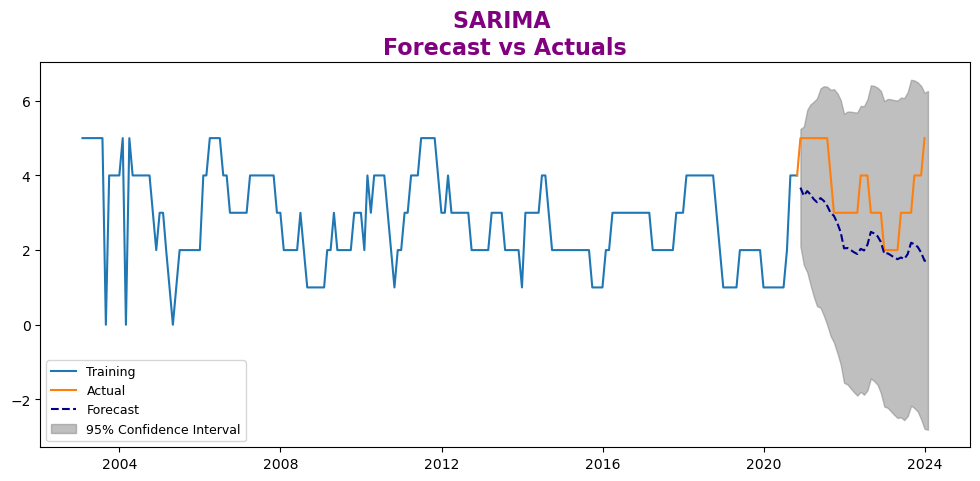

In [65]:
best_model = SARIMAX(data_train.tolist(), order = (3, 0, 1), seasonal_order = (3, 0, 1, 12)).fit(method='powell')
forecast_results = best_model.get_forecast(steps=39)


forecast_values = forecast_results.predicted_mean


confidence_intervals = forecast_results.conf_int()
forecast_index = pd.date_range(start=data_train.index[-1]+ pd.offsets.MonthEnd(1), periods=39,freq='M')
fc_series = pd.Series(forecast_values, index=forecast_index)


forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': confidence_intervals[:, 0],
    'Upper CI': confidence_intervals[:, 1]
}, index=forecast_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train, label='Training')
plt.plot(data_test, label='Actual')
plt.plot(fc_series, label='Forecast',color="darkblue",linestyle='--')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                 color='gray', alpha=0.5, label='95% Confidence Interval')

plt.title('SARIMA \nForecast vs Actuals',fontsize= 16, fontweight= 'bold', color= 'purple')
plt.legend(loc='lower left', fontsize=9)
plt.show()

Visually, this graph is better as we see that the forecast has more fluctuations, but we will use metrics to evaluate it.

In [66]:
data_train.shape, data_test.shape

((214,), (39,))

In [67]:
start = len(data_train)
end = len(data_train) + len(data_test) - 1

# Get predictions
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels')

# Convert predictions to a pandas Series
predictions_series = pd.Series(predictions, index=data_test.index, name='SARIMA Predictions')


C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [68]:
data_test = pd.Series(data_test)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [69]:
new_metrics = calculate_metrics(data_test, predictions_series)
new_metrics["State"]="Sonora"
new_metrics["Model"]="Sarima"
new_metrics["Scaled"]="No"
evaluation_results = pd.concat([evaluation_results, pd.DataFrame([new_metrics])], ignore_index=True)
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,State,Model,Scaled
0,0.097926,0.763353,0.912156,0.955069,20.263722,Sonora,Arima,No
1,-0.855675,1.179551,1.876416,1.369823,30.674837,Sonora,Sarima,No


We can see that our results with SARIMA are worse than with ARIMA, with a negative R² and larger errors. Therefore, we will try scaling the data and starting over to see if our models improve.

### ARIMA (scaled)

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
scaler = StandardScaler()

df_scaled_values = scaler.fit_transform(orig_df2[["Sonora"]])
df_scaled = pd.DataFrame(df_scaled_values, columns=["Sonora"], index=orig_df2.index)

In [72]:
df_scaled.head()

,Sonora
2003-01-31,1.739253
2003-02-28,1.739253
2003-03-31,1.739253
2003-04-30,1.739253
2003-05-31,1.739253


In [73]:
aic_values = []

for ari in range(1, 4):  # p
    for d in range(0, 4):  # d
        for maj in range(0, 4):  # q
            try:
                
                arima_model = ARIMA(df_scaled["Sonora"].tolist(), order=(ari, d, maj))
                arima_model_fit = arima_model.fit()
                
                
                aic_values.append([ari, d, maj, arima_model_fit.aic])
            except ValueError:
                continue 


aic_df = pd.DataFrame(aic_values, columns=['p', 'd', 'q', 'AIC'])


best_aic_row = aic_df.loc[aic_df['AIC'].idxmin()]

print(aic_values)
print(f"Best AIC: {best_aic_row['AIC']}")
print(f"Parameters: p={best_aic_row['p']}, d={best_aic_row['d']}, q={best_aic_row['q']}")

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[[1, 0, 0, 502.94080438900886], [1, 0, 1, 495.0051535214592], [1, 0, 2, 491.6326182596596], [1, 0, 3, 493.2708455813316], [1, 1, 0, 501.85927886113603], [1, 1, 1, 503.84763524086213], [1, 1, 2, 502.95585691522564], [1, 1, 3, 504.86237749057113], [1, 2, 0, 628.4196825434676], [1, 2, 1, 508.94255167571055], [1, 2, 2, 510.9404236235373], [1, 2, 3, 510.1137327652123], [1, 3, 0, 850.8766814815883], [1, 3, 1, 635.4420045394479], [1, 3, 2, 522.7974318821896], [1, 3, 3, 524.7760702245346], [2, 0, 0, 492.09249496208764], [2, 0, 1, 493.3367975668382], [2, 0, 2, 490.718883111687], [2, 0, 3, 493.4088432652326], [2, 1, 0, 503.8477180344721], [2, 1, 1, 493.2257675847422], [2, 1, 2, 507.8475341312989], [2, 1, 3, 496.6616270135571], [2, 2, 0, 587.5972294296516], [2, 2, 1, 510.94000472829543], [2, 2, 2, 510.56549133119], [2, 2, 3, 512.0300661374166], [2, 3, 0, 763.0606677835779], [2, 3, 1, 595.4566143377009], [2, 3, 2, 524.8539243662192], [2, 3, 3, 526.7761890799613], [3, 0, 0, 492.9700142537419], [3, 

In [74]:
Sonora_scaled=df_scaled["Sonora"]

In [75]:
p_train1 = 0.85 ### 15% for test data

train1 = Sonora_scaled[:int(len(Sonora_scaled) * p_train1)]
test1 = Sonora_scaled[int(len(Sonora_scaled) * p_train1):]
train1

2003-01-31    1.739253
2003-02-28    1.739253
2003-03-31    1.739253
2003-04-30    1.739253
2003-05-31    1.739253
                ...   
2020-06-30   -1.581139
2020-07-31   -0.751041
2020-08-31    0.909155
2020-09-30    0.909155
2020-10-31    0.909155
Freq: M, Name: Sonora, Length: 214, dtype: float64

In [76]:
len(test1)

38

Train dates : 2003-01-31 00:00:00 --- 2020-10-31 00:00:00  (n=214)
Test dates  : 2020-10-31 00:00:00 --- 2023-12-31 00:00:00  (n=39)


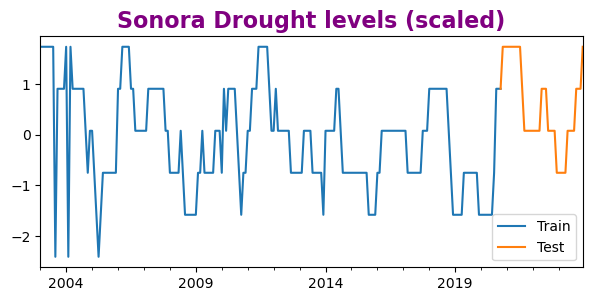

In [77]:
fin_train = '2020-10-31 00:00:00'
print(
    f"Train dates : {Sonora_scaled.index.min()} --- {Sonora_scaled.loc[:fin_train].index.max()}  "
    f"(n={len(Sonora_scaled.loc[:fin_train])})"
)
print(
    f"Test dates  : {Sonora_scaled.loc[fin_train:].index.min()} --- {Sonora_scaled.loc[:].index.max()}  "
    f"(n={len(Sonora_scaled.loc[fin_train:])})"
)
data_train = Sonora_scaled.loc[:fin_train]
data_test  = Sonora_scaled.loc[fin_train:]


fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='Train')
data_test.plot(ax=ax, label='Test')
ax.set_title('Sonora Drought levels (scaled)',fontsize= 16, fontweight= 'bold', color= 'purple')
ax.legend();

In [78]:
arima_obj_So = ARIMA(data_train.tolist(), order = (3, 0, 1))

model_So_fit = arima_obj_So.fit()

model_So_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  214
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -213.098
Date:                Tue, 05 Nov 2024   AIC                            438.196
Time:                        01:14:01   BIC                            458.392
Sample:                             0   HQIC                           446.357
                                - 214                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0766      0.150     -0.510      0.610      -0.371       0.218
ar.L1          1.4738      0.109     13.577      0.000       1.261       1.687
ar.L2         -0.2400      0.097     -2.472      0.013      -0.430      -0.050
ar.L3         -0.2676      0.052     -5.178      0.000      -0.369      -0.166
ma.L1         -0.9085      0.108     -8.377      0.000      -1.121      -0.696
sigma2         0.4269      0.032     13.510      0.000       0.365       0.489
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               701.34
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
forecast_obj = model_So_fit.get_forecast(steps=38)
forecast_values = forecast_obj.predicted_mean  
confidence_intervals = forecast_obj.conf_int(alpha=0.05) 

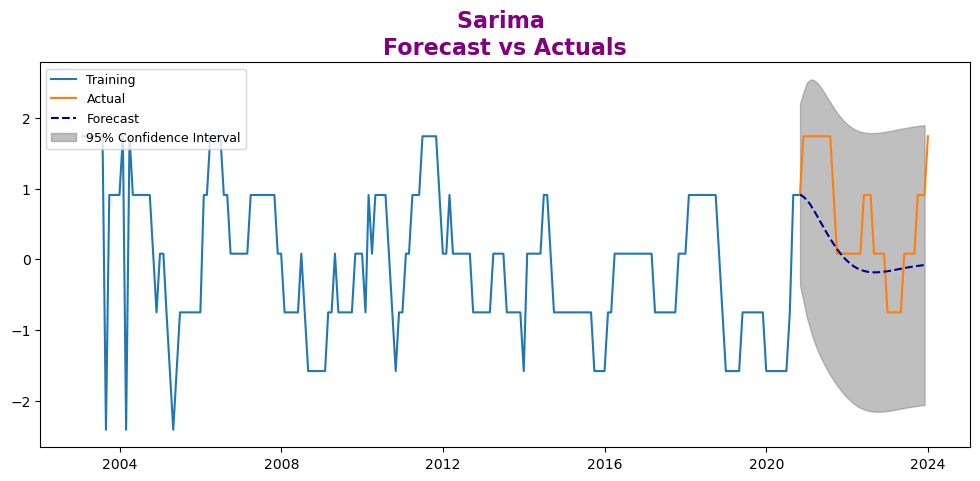

In [80]:
forecast_index = pd.date_range(start=data_train.index[-1], periods=38,freq='M')
fc_series = pd.Series(forecast_values, index=forecast_index)


forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': confidence_intervals[:, 0],
    'Upper CI': confidence_intervals[:, 1]
}, index=forecast_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train, label='Training')
plt.plot(data_test, label='Actual')
plt.plot(fc_series, label='Forecast',color="darkblue",linestyle='--')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                 color='gray', alpha=0.5, label='95% Confidence Interval')

plt.title('Sarima \nForecast vs Actuals',fontsize= 16, fontweight= 'bold', color= 'purple')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [81]:
start = len(data_train)
end = len(data_train) + len(data_test) - 1

predictions = model_So_fit.predict(start=start, end=end, dynamic=False, typ='levels')

predictions_series = pd.Series(predictions, index=data_test.index, name='ARIMA Predictions')


C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [82]:
data_test = pd.Series(data_test)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [83]:
new_metrics = calculate_metrics(data_test, predictions_series)
new_metrics["State"]="Sonora"
new_metrics["Model"]="Arima"
new_metrics["Scaled"]="Yes"
evaluation_results = pd.concat([evaluation_results, pd.DataFrame([new_metrics])], ignore_index=True)
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,State,Model,Scaled
0,0.097926,0.763353,0.912156,0.955069,20.263722,Sonora,Arima,No
1,-0.855675,1.179551,1.876416,1.369823,30.674837,Sonora,Sarima,No
2,0.097920,0.633662,0.628537,0.792803,137.867571,Sonora,Arima,Yes


Now we will use SARIMA with the scaled data to compare the four models
### SARIMA (scaled)

In [84]:
best_model = SARIMAX(Sonora_scaled, order = (3, 0, 1), seasonal_order = (3, 0, 1, 12)).fit(method='powell')

print(best_model.summary())

Optimization terminated successfully.
         Current function value: 0.948948
         Iterations: 3
         Function evaluations: 297
                                     SARIMAX Results                                      
Dep. Variable:                             Sonora   No. Observations:                  252
Model:             SARIMAX(3, 0, 1)x(3, 0, 1, 12)   Log Likelihood                -239.135
Date:                            Tue, 05 Nov 2024   AIC                            496.270
Time:                                    01:14:02   BIC                            528.035
Sample:                                01-31-2003   HQIC                           509.051
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

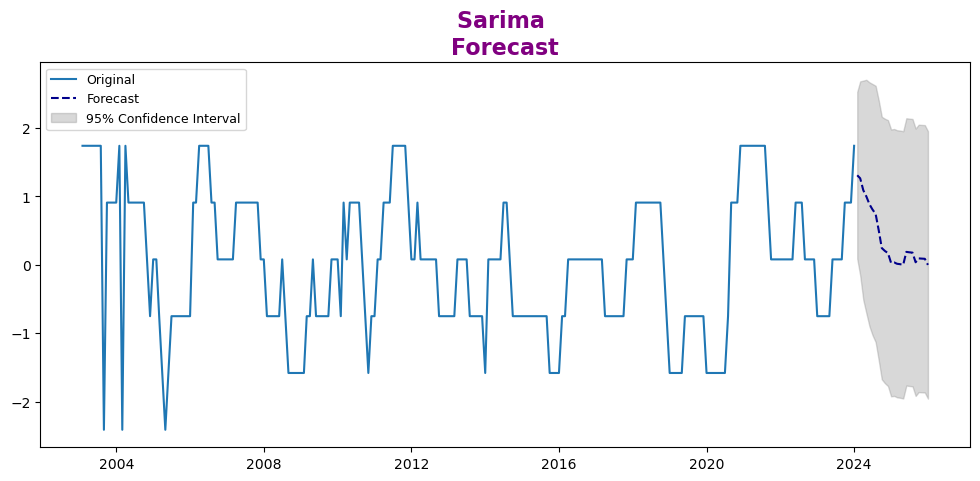

In [85]:
forecast_results = best_model.get_forecast(steps=24)

forecast_values = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int()

forecast_index = pd.date_range(start=Sonora_scaled.index[-1] + pd.offsets.MonthEnd(1), periods=24, freq='M')

forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': confidence_intervals.iloc[:, 0],
    'Upper CI': confidence_intervals.iloc[:, 1]
}, index=forecast_index)

plt.figure(figsize=(12, 5), dpi=100)
plt.plot(Sonora_scaled, label='Original')

plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast',color="darkblue",linestyle='--')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

plt.title('Sarima \nForecast',fontsize= 16, fontweight= 'bold', color= 'purple')
plt.legend(loc='upper left', fontsize=9)
plt.show()

Optimization terminated successfully.
         Current function value: 0.990222
         Iterations: 3
         Function evaluations: 304


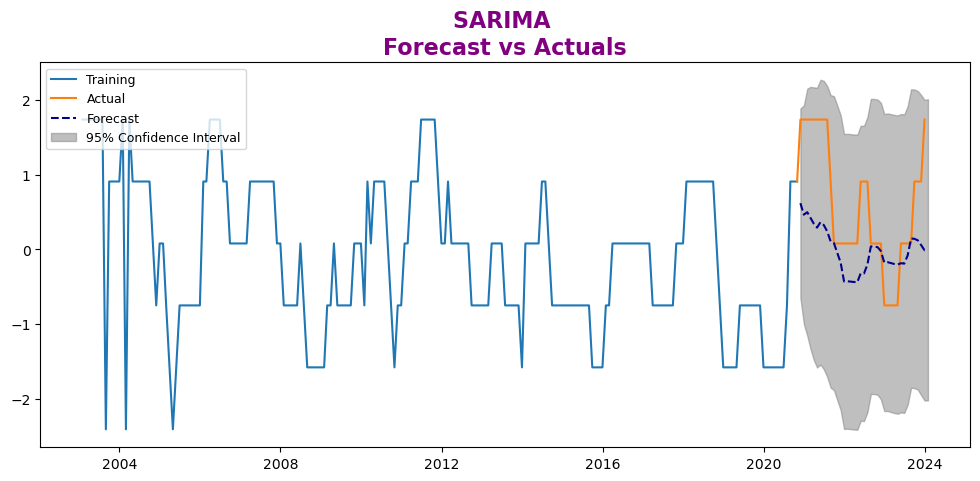

In [86]:
best_model = SARIMAX(data_train.tolist(), order = (3, 0, 1), seasonal_order = (3, 0, 1, 12)).fit(method='powell')
forecast_results = best_model.get_forecast(steps=39)


forecast_values = forecast_results.predicted_mean


confidence_intervals = forecast_results.conf_int()
forecast_index = pd.date_range(start=data_train.index[-1]+ pd.offsets.MonthEnd(1), periods=39,freq='M')
fc_series = pd.Series(forecast_values, index=forecast_index)


forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': confidence_intervals[:, 0],
    'Upper CI': confidence_intervals[:, 1]
}, index=forecast_index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train, label='Training')
plt.plot(data_test, label='Actual')
plt.plot(fc_series, label='Forecast',color="darkblue",linestyle='--')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                 color='gray', alpha=0.5, label='95% Confidence Interval')

plt.title('SARIMA \nForecast vs Actuals',fontsize= 16, fontweight= 'bold', color= 'purple')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [87]:
start = len(data_train)
end = len(data_train) + len(data_test) - 1

predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels')
predictions_series = pd.Series(predictions, index=data_test.index, name='SARIMA Predictions')
data_test = pd.Series(data_test)
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\dnisg\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [88]:
new_metrics = calculate_metrics(data_test, predictions_series)
new_metrics["State"]="Sonora"
new_metrics["Model"]="Sarima"
new_metrics["Scaled"]="Yes"
evaluation_results = pd.concat([evaluation_results, pd.DataFrame([new_metrics])], ignore_index=True)
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,State,Model,Scaled
0,0.097926,0.763353,0.912156,0.955069,20.263722,Sonora,Arima,No
1,-0.855675,1.179551,1.876416,1.369823,30.674837,Sonora,Sarima,No
2,0.097920,0.633662,0.628537,0.792803,137.867571,Sonora,Arima,Yes
3,-0.125145,0.728109,0.783961,0.885416,191.459441,Sonora,Sarima,Yes


It improved a little compared to the unscaled SARIMA, but as we can see, the best result is with scaled ARIMA, not taking into account that the MAPE is very high due to our data having very small values, which makes the error larger.

We will try using other methods to compare and find the most accurate model.

### Holt-Winters Exponential Smoothing

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 

from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

we decompose the Time Series and will look for Levels, Trends and Seasonality in the data.

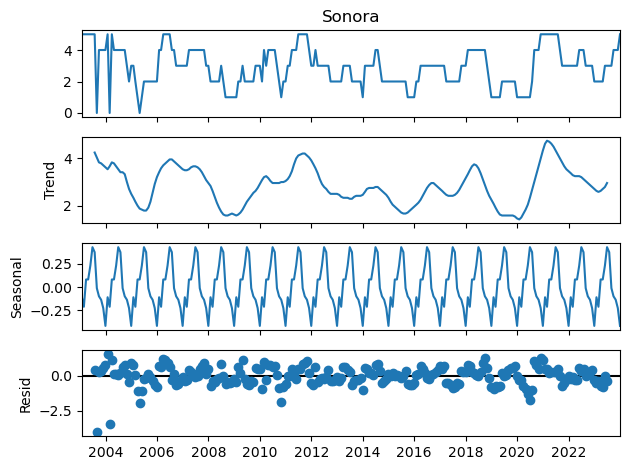

In [90]:
decompose_result = seasonal_decompose(df_new2["Sonora"], model = 'additive')

decompose_result.plot()
plt.show()

we can see the data does not have trend but seasonality.

In [91]:
m = 12
alpha = 1/(2 * m)

In [92]:
df_Sonora = pd.DataFrame(df_new2["Sonora"])

### Single HWES

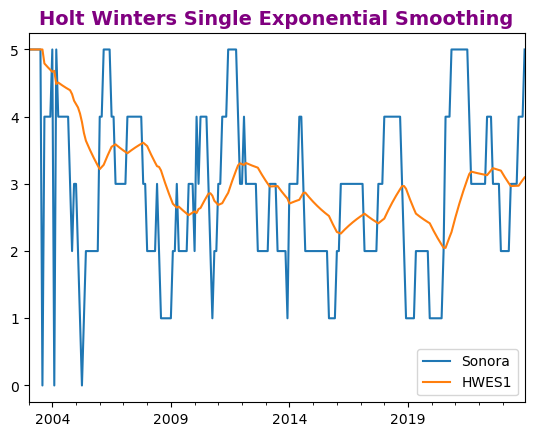

In [93]:
df_Sonora["HWES1"] = SimpleExpSmoothing(df_Sonora["Sonora"]).fit(
                                                    smoothing_level = alpha, optimized = False, use_brute = True).fittedvalues
ax=df_Sonora[['Sonora','HWES1']].plot();
ax.set_title('Holt Winters Single Exponential Smoothing',fontsize= 14, fontweight= 'bold', color= 'purple')
plt.show()

It is clear from the above plot that forecast did not fit quite well. We used simple exponential smoothing (SES) and it doesn’t work for data with Seasonality.

### Double HWES

We will fit the data on Double ES on both Additive and Multiplicative Trend.

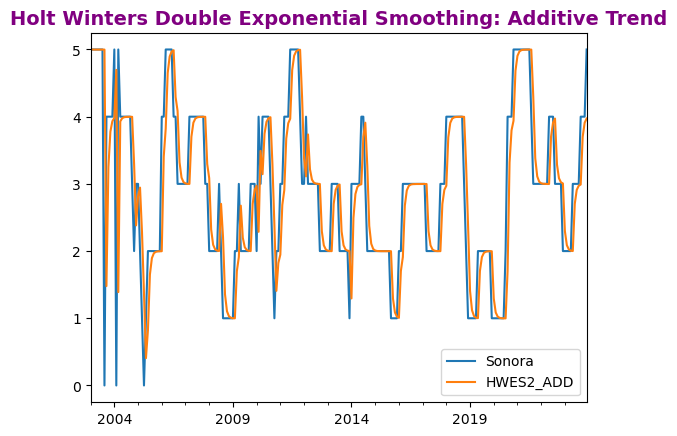

In [94]:
df_Sonora['HWES2_ADD'] = ExponentialSmoothing(df_Sonora['Sonora'], trend = 'add').fit().fittedvalues

ax=df_Sonora[['Sonora', 'HWES2_ADD']].plot()
ax.set_title('Holt Winters Double Exponential Smoothing: Additive Trend',fontsize= 14, fontweight= 'bold', color= 'purple');


### Triple HWES

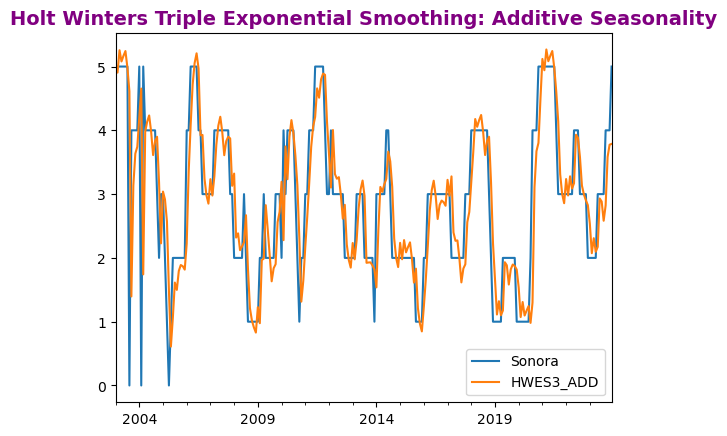

In [95]:
df_Sonora['HWES3_ADD'] = ExponentialSmoothing(df_Sonora['Sonora'], 
                                               trend = 'add', seasonal = 'add', seasonal_periods = 12).fit().fittedvalues

ax=df_Sonora[['Sonora','HWES3_ADD']].plot()
ax.set_title('Holt Winters Triple Exponential Smoothing: Additive Seasonality',fontsize= 14, fontweight= 'bold', color= 'purple');

### Forecasting with Holt-Winters Exponential Smoothing (Triple ES)

In [96]:
forecast_data = pd.DataFrame(df_new2["Sonora"])
train_data = forecast_data[:214] ###85%
test_data = forecast_data[214:]

train_data.shape, test_data.shape

((214, 1), (38, 1))

R2 Score (SES): -0.11
R2 Score (Holt): 0.00
R2 Score (Holt-Winters): -0.03


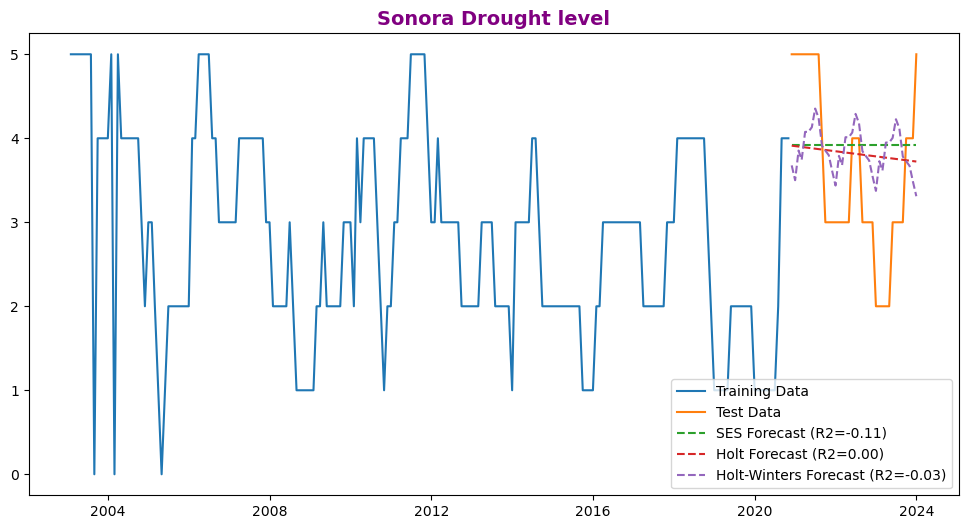

In [97]:
model_ses = SimpleExpSmoothing(train_data).fit(optimized=True)
forecast_ses = model_ses.forecast(steps=len(test_data))
r2_ses = r2_score(test_data, forecast_ses)

# Holt's Method (Double Exponential Smoothing)
model_holt = ExponentialSmoothing(train_data, trend='add').fit(optimized=True)
forecast_holt = model_holt.forecast(steps=len(test_data))
r2_holt = r2_score(test_data, forecast_holt)

# Holt-Winters Method (Triple Exponential Smoothing)
model_hw = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)
forecast_hw = model_hw.forecast(steps=len(test_data))
r2_hw = r2_score(test_data, forecast_hw)

# Print the R2 scores
print(f"R2 Score (SES): {r2_ses:.2f}")
print(f"R2 Score (Holt): {r2_holt:.2f}")
print(f"R2 Score (Holt-Winters): {r2_hw:.2f}")

# Ploat the results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(forecast_ses, label=f'SES Forecast (R2={r2_ses:.2f})', linestyle='--')
plt.plot(forecast_holt, label=f'Holt Forecast (R2={r2_holt:.2f})', linestyle='--')
plt.plot(forecast_hw, label=f'Holt-Winters Forecast (R2={r2_hw:.2f})', linestyle='--')
plt.legend(loc='lower right')
plt.title('Sonora Drought level',fontsize= 14, fontweight= 'bold', color= 'purple')
plt.show()

As we can see, our data with Single, Double, or Triple Exponential Smoothing did not perform well. Therefore, we will stick with the one that gave us the best results.

In [98]:
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,State,Model,Scaled
0,0.097926,0.763353,0.912156,0.955069,20.263722,Sonora,Arima,No
1,-0.855675,1.179551,1.876416,1.369823,30.674837,Sonora,Sarima,No
2,0.097920,0.633662,0.628537,0.792803,137.867571,Sonora,Arima,Yes
3,-0.125145,0.728109,0.783961,0.885416,191.459441,Sonora,Sarima,Yes


In [99]:
arima_obj_So = ARIMA(Sonora_scaled, order = (3, 0, 1))

model_So_fit = arima_obj_So.fit()


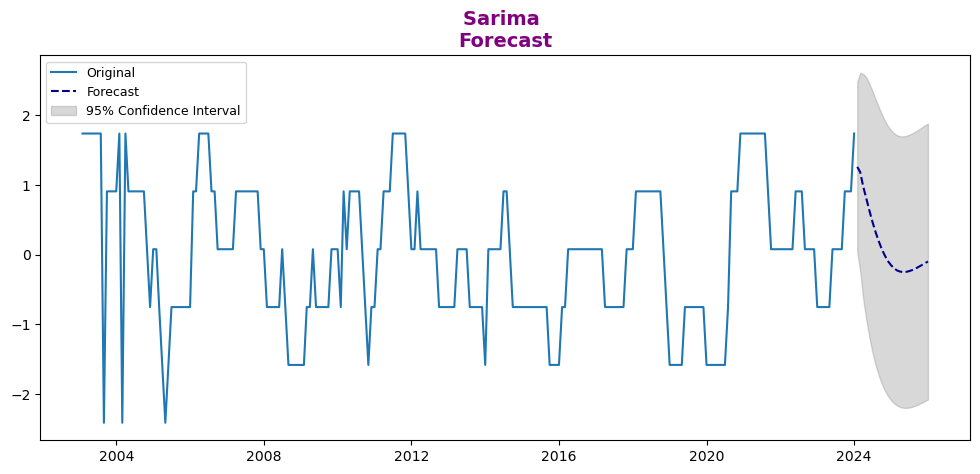

In [100]:
forecast_results = model_So_fit.get_forecast(steps=24)

forecast_values = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int()

forecast_index = pd.date_range(start=Sonora_scaled.index[-1] + pd.offsets.MonthEnd(1), periods=24, freq='M')

forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': confidence_intervals.iloc[:, 0],
    'Upper CI': confidence_intervals.iloc[:, 1]
}, index=forecast_index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(Sonora_scaled, label='Original')

plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast',color="darkblue",linestyle='--')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

plt.title('Sarima \nForecast',fontsize= 14, fontweight= 'bold', color= 'purple')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [101]:
forecast_values=pd.DataFrame(forecast_values)
forecast_values.head()

,predicted_mean
2024-01-31,1.260460
2024-02-29,1.187057
2024-03-31,0.973151
2024-04-30,0.805031
2024-05-31,0.629651


In [102]:
forecast_original = scaler.inverse_transform(forecast_values)

In [103]:
forecast_original_df = pd.DataFrame(forecast_original, index=forecast_values.index, columns=["Sonora_Forecast"])
forecast_original_df.head()

,Sonora_Forecast
2024-01-31,4.423209
2024-02-29,4.334782
2024-03-31,4.077095
2024-04-30,3.874565
2024-05-31,3.663288
